<a href="https://colab.research.google.com/github/costpetrides/FAIRMODE-WG5/blob/main/Python/IDW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IDW Method

In [1]:
pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.8 MB/s eta 0:00:00


In [2]:
pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 30.3 MB/s eta 0:00:00


# IDW - Additive Method

In [42]:
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time  # Για μέτρηση χρόνου εκτέλεσης
from tqdm import tqdm  # Progress bar

# === 1. Φόρτωση των δεδομένων των σταθμών ===
data = pd.read_csv("basePM25nearest_grid.csv")

# Υπολογισμός του bias (Observed - Modeled)
data["PM25_Bias"] = data["SURF_ug_PM25_rh50"] - data["nearest_SURF_ug_PM25_rh50"]

# Εξαγωγή των χωρικών συντεταγμένων και των τιμών bias
station_coords = data[["lon", "lat"]].values
bias_values = data["PM25_Bias"].values

# === 2. Ορισμός του εύρους και του βήματος για τις υπερπαραμέτρους ===
power_values = np.arange(0.5, 32, 2).tolist()
neighbor_values = np.arange(5, 200, 5).tolist()
kfold = 50  # Σταθερή τιμή για το K-Fold

# Αποθήκευση των αποτελεσμάτων
results = []

# === 3. Εκτέλεση Grid Search με Progress Bar ===
start_time = time.time()  # Μέτρηση χρόνου εκτέλεσης
kf = KFold(n_splits=kfold, shuffle=True, random_state=42)

# Υπολογισμός συνολικών συνδυασμών για το K, ώστε να φτιάξουμε progress bar
total_combinations = len(power_values) * len(neighbor_values)

with tqdm(total=total_combinations, desc=f"Processing with K={kfold}") as pbar:
    for p in power_values:
        for k in neighbor_values:
            rmse_values, mae_values, r2_values = [], [], []

            # === 3.1 Διαδικασία K-Fold Cross Validation ===
            for train_index, test_index in kf.split(station_coords):
                train_coords, test_coords = station_coords[train_index], station_coords[test_index]
                train_bias, test_bias = bias_values[train_index], bias_values[test_index]

                tree = cKDTree(train_coords)
                distances, indices = tree.query(test_coords, k=k)

                distances[distances == 0] = 1e-10  # Αποφυγή διαίρεσης με το μηδέν
                weights = 1.0 / np.power(distances, p)
                weights /= weights.sum(axis=1, keepdims=True)

                predicted_bias = np.sum(weights * train_bias[indices], axis=1)

                # Υπολογισμός των στατιστικών μετρικών
                rmse_values.append(np.sqrt(mean_squared_error(test_bias, predicted_bias)))
                mae_values.append(mean_absolute_error(test_bias, predicted_bias))
                r2_values.append(r2_score(test_bias, predicted_bias))

            # === 3.2 Αποθήκευση των μέσων τιμών RMSE, MAE, R² για κάθε συνδυασμό ===
            results.append((p, k, np.mean(rmse_values), np.mean(mae_values), np.mean(r2_values)))

            # Ενημέρωση της progress bar
            pbar.update(1)

execution_time = time.time() - start_time
print(f"✔ Completed with K={kfold} in {execution_time:.2f} seconds")

# === 4. Μετατροπή των αποτελεσμάτων σε Pandas DataFrame ===
results_df = pd.DataFrame(results, columns=["Power", "Neighbors", "RMSE", "MAE", "R2"])

# === 5. Εμφάνιση και αποθήκευση των αποτελεσμάτων ===
print("\n Final Results:")
print(results_df)  # Εμφάνιση όλων των αποτελεσμάτων

# Αποθήκευση σε αρχείο CSV για περαιτέρω ανάλυση
results_df.to_csv("BaseCase_PM25_Y_IDW_add.Val.csv", index=False)

# === 6. Εύρεση του καλύτερου συνδυασμού υπερπαραμέτρων ===
best_row = results_df.loc[results_df["RMSE"].idxmin()]
best_p, best_k, best_rmse, best_mae, best_r2 = best_row.values

print(f"\n Best hyperparameters: p={best_p}, k={best_k} → RMSE: {best_rmse:.4f}, MAE: {best_mae:.4f}, R²: {best_r2:.4f}")


Processing with K=50: 100%|██████████| 624/624 [02:21<00:00,  4.41it/s]

✔ Completed with K=50 in 141.42 seconds

 Final Results:
     Power  Neighbors      RMSE       MAE        R2
0      0.5          5  0.518392  0.179995  0.880229
1      0.5         10  0.504821  0.182868  0.890693
2      0.5         15  0.519836  0.194771  0.883374
3      0.5         20  0.536512  0.205321  0.876332
4      0.5         25  0.547637  0.214560  0.872632
..     ...        ...       ...       ...       ...
619   30.5        175  0.569522  0.194721  0.851261
620   30.5        180  0.569522  0.194721  0.851261
621   30.5        185  0.569522  0.194721  0.851261
622   30.5        190  0.569522  0.194721  0.851261
623   30.5        195  0.569522  0.194721  0.851261

[624 rows x 5 columns]

 Best hyperparameters: p=2.5, k=155.0 → RMSE: 0.4935, MAE: 0.1879, R²: 0.8902


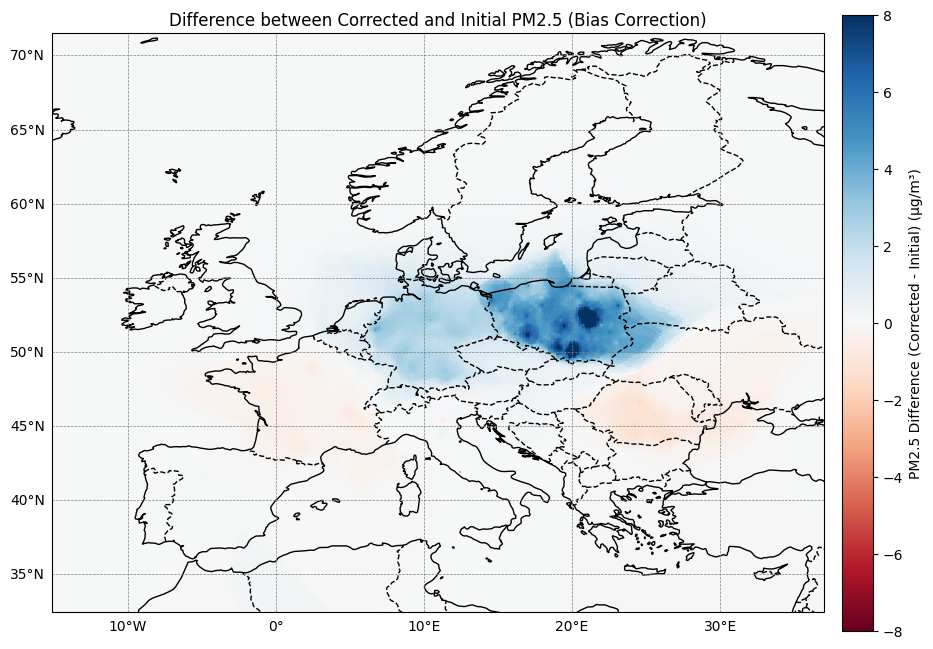

In [32]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === Load the Initial and Corrected NetCDF Files ===
initial_netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
corrected_netcdf_path = "BaseCase_PM25_Y_IDW_add.nc"  # Change this if needed

# Open NetCDF datasets
ds_initial = xr.open_dataset(initial_netcdf_path)
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract PM2.5 data (Ensure no time dimension)
initial_pm25 = ds_initial["SURF_ug_PM25_rh50"].squeeze().values
corrected_pm25 = ds_corrected["SURF_ug_PM25_rh50_corrected"].squeeze().values

# Compute difference (Corrected - Initial) and ensure correct shape
difference = (corrected_pm25 - initial_pm25).squeeze()

# Extract coordinates
lon = ds_initial["lon"].values
lat = ds_initial["lat"].values

# === Define Plot Limits ===
cbar_min = -8
cbar_max = 8

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the difference (Ensure shape consistency)
im = ax.pcolormesh(lon, lat, difference, transform=ccrs.PlateCarree(), cmap="RdBu", vmin=cbar_min, vmax=cbar_max, shading='auto')

# Add colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("PM2.5 Difference (Corrected - Initial) (µg/m³)")

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.title("Difference between Corrected and Initial PM2.5 (Bias Correction)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close datasets
ds_initial.close()
ds_corrected.close()


# IDW - Rescaled Additive Method

In [43]:
import os
import numpy as np
import pandas as pd
import netCDF4 as nc
from scipy.spatial import cKDTree
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import itertools

# === Φόρτωση δεδομένων από CSV ===
csv_file_path = "basePM25nearest_grid.csv"
df = pd.read_csv(csv_file_path)

# Υπολογισμός bias
df["bias"] = df["SURF_ug_PM25_rh50"] - df["nearest_SURF_ug_PM25_rh50"]

# === Φόρτωση NetCDF ===
netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
dataset = nc.Dataset(netcdf_path, "r")

# Εξαγωγή δεδομένων πλέγματος
lon = dataset.variables["lon"][:]
lat = dataset.variables["lat"][:]
pm25_modeled = dataset.variables["SURF_ug_PM25_rh50"][0, :, :]

# Δημιουργία meshgrid
lon_mesh, lat_mesh = np.meshgrid(lon, lat)
points_grid = np.column_stack([lon_mesh.ravel(), lat_mesh.ravel()])

# Προετοιμασία δεδομένων σταθμών
station_points = df[["nearest_grid_lon", "nearest_grid_lat"]].values
bias_values = df["bias"].values

# Κατασκευή KDTree για αποδοτική αναζήτηση γειτονικών σημείων
tree = cKDTree(station_points)

# === Εύρος τιμών για p και k ===
p_values =  np.arange(0.5, 32, 2).tolist()
k_values = np.arange(5, 200, 5).tolist()

# === Grid Search για τα καλύτερα p και k ===
kf = KFold(n_splits=10, shuffle=True, random_state=42)  # Χρησιμοποιούμε 10-Fold Cross Validation
results = []
best_rmse = float("inf")
best_params = None

with tqdm(total=len(p_values) * len(k_values), desc="Grid Search with K-Fold") as pbar:
    for p, k in itertools.product(p_values, k_values):
        fold_rmses = []
        fold_maes = []
        fold_r2s = []

        for train_index, test_index in kf.split(station_points):
            train_points, test_points = station_points[train_index], station_points[test_index]
            train_values, test_values = bias_values[train_index], bias_values[test_index]

            train_tree = cKDTree(train_points)
            predicted_bias = []

            for test_point in test_points:
                dists, idxs = train_tree.query(test_point, k=k)

                if np.any(dists == 0):
                    predicted_bias.append(train_values[idxs[dists == 0]][0])
                else:
                    weights = 1 / (dists ** p)
                    interpolated_bias = np.sum(weights * train_values[idxs]) / np.sum(weights)
                    predicted_bias.append(interpolated_bias)

            fold_rmse = np.sqrt(mean_squared_error(test_values, predicted_bias))
            fold_mae = np.mean(np.abs(np.array(test_values) - np.array(predicted_bias)))
            fold_r2 = 1 - (np.sum((np.array(test_values) - np.array(predicted_bias)) ** 2) /
                           np.sum((np.array(test_values) - np.mean(test_values)) ** 2))

            fold_rmses.append(fold_rmse)
            fold_maes.append(fold_mae)
            fold_r2s.append(fold_r2)

        # Μέσοι όροι από όλα τα folds για αυτόν τον συνδυασμό p, k
        mean_rmse = np.mean(fold_rmses)
        mean_mae = np.mean(fold_maes)
        mean_r2 = np.mean(fold_r2s)

        results.append((p, k, mean_rmse, mean_mae, mean_r2))

        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_params = (p, k)

        pbar.update(1)

# Αποθήκευση αποτελεσμάτων grid search σε CSV
results_df = pd.DataFrame(results, columns=["p", "k", "RMSE", "MAE", "R2"])
results_df.to_csv("BaseCase_PM25_rh50_Y_IDW_resc_Val.csv", index=False)

print(f"\nBest parameters found: p={best_params[0]}, k={best_params[1]} with Mean RMSE={best_rmse:.4f}")

# === Εφαρμογή IDW Rescaled Additive με τα βέλτιστα p, k ===
def idw_rescaled_additive(grid_points, station_points, values, pm25_modeled, p, k):
    interpolated = np.zeros(grid_points.shape[0])

    grid_tree = cKDTree(points_grid)

    for i in tqdm(range(grid_points.shape[0]), desc="Interpolating IDW Rescaled Additive", unit="grid point"):
        dists, idxs = tree.query(grid_points[i], k=k)

        if np.any(dists == 0):
            interpolated[i] = values[idxs[dists == 0]][0]
            continue

        weights = np.reciprocal(dists**p, where=dists > 0)
        _, grid_idx = grid_tree.query(station_points[idxs])
        pm25_grid_values = pm25_modeled.ravel()[grid_idx]

        scaling_factor = np.sum(weights * pm25_grid_values) / np.sum(weights)
        interpolated[i] = scaling_factor * np.dot(weights, values[idxs]) / np.sum(weights)

    return interpolated

print("\nInterpolating bias using IDW Rescaled Additive with optimized parameters...")
interpolated_bias_rescaled = idw_rescaled_additive(points_grid, station_points, bias_values, pm25_modeled, best_params[0], best_params[1])
interpolated_bias_rescaled = interpolated_bias_rescaled.reshape(pm25_modeled.shape)

corrected_pm25_rescaled = pm25_modeled + interpolated_bias_rescaled

# === Αποθήκευση του διορθωμένου NetCDF ===
corrected_netcdf_path = "BaseCase_PM25_rh50_Y_IDW_resc.nc"
if os.path.exists(corrected_netcdf_path):
    os.remove(corrected_netcdf_path)

new_dataset = nc.Dataset(corrected_netcdf_path, "w", format="NETCDF4")
new_dataset.createDimension("lat", lat.shape[0])
new_dataset.createDimension("lon", lon.shape[0])
lat_var = new_dataset.createVariable("lat", "f4", ("lat",))
lon_var = new_dataset.createVariable("lon", "f4", ("lon",))
pm25_var = new_dataset.createVariable("SURF_ug_PM25_rh50_corrected", "f4", ("lat", "lon"))

pm25_var.setncatts(dataset.variables["SURF_ug_PM25_rh50"].__dict__)
new_dataset.description = "Bias-corrected PM2.5 using IDW Rescaled Additive with K-Fold (Optimized p & k, No Time Dimension)"

lat_var[:] = lat
lon_var[:] = lon
pm25_var[:, :] = corrected_pm25_rescaled

new_dataset.close()
dataset.close()

print("Bias correction using IDW Rescaled Additive with K-Fold completed successfully! Corrected NetCDF file saved as", corrected_netcdf_path)


Grid Search with K-Fold: 100%|██████████| 624/624 [03:07<00:00,  3.33it/s]



Best parameters found: p=2.5, k=175 with Mean RMSE=0.4974

Interpolating bias using IDW Rescaled Additive with optimized parameters...


Interpolating IDW Rescaled Additive: 100%|██████████| 406901/406901 [03:40<00:00, 1845.04grid point/s]

Bias correction using IDW Rescaled Additive with K-Fold completed successfully! Corrected NetCDF file saved as BaseCase_PM25_rh50_Y_IDW_resc.nc


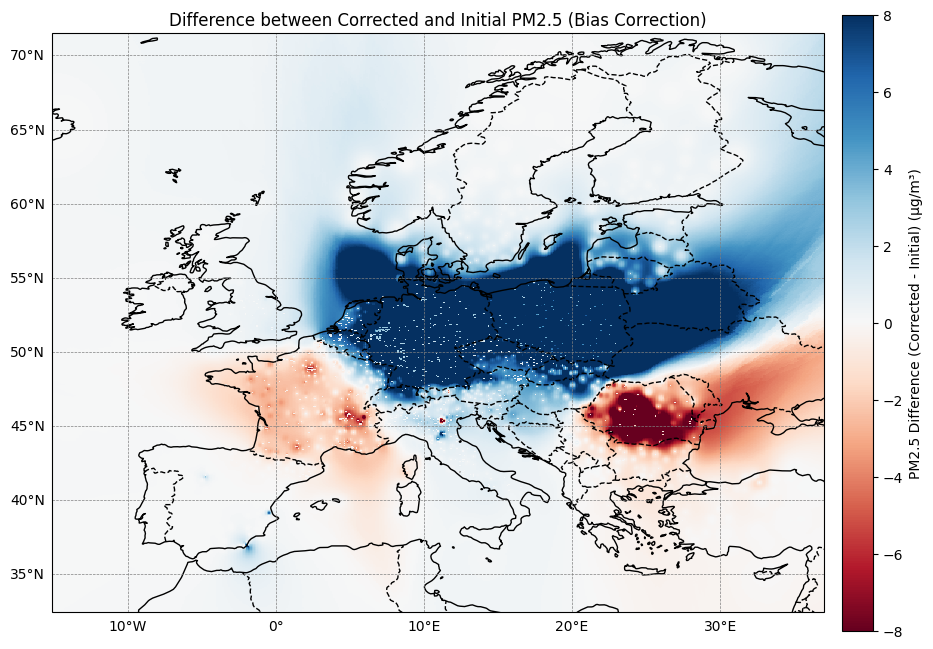

In [44]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === Load the Initial and Corrected NetCDF Files ===
initial_netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
corrected_netcdf_path = "BaseCase_PM25_rh50_Y_IDW_resc.nc"  # Change this if needed

# Open NetCDF datasets
ds_initial = xr.open_dataset(initial_netcdf_path)
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract PM2.5 data (Ensure no time dimension)
initial_pm25 = ds_initial["SURF_ug_PM25_rh50"].squeeze().values
corrected_pm25 = ds_corrected["SURF_ug_PM25_rh50_corrected"].squeeze().values

# Compute difference (Corrected - Initial) and ensure correct shape
difference = (corrected_pm25 - initial_pm25).squeeze()

# Extract coordinates
lon = ds_initial["lon"].values
lat = ds_initial["lat"].values

# === Define Plot Limits ===
cbar_min = -8
cbar_max = 8

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the difference (Ensure shape consistency)
im = ax.pcolormesh(lon, lat, difference, transform=ccrs.PlateCarree(), cmap="RdBu", vmin=cbar_min, vmax=cbar_max, shading='auto')

# Add colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("PM2.5 Difference (Corrected - Initial) (µg/m³)")

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.title("Difference between Corrected and Initial PM2.5 (Bias Correction)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close datasets
ds_initial.close()
ds_corrected.close()


# IDW- Multiplicative Mehod

In [49]:
import os
import numpy as np
import pandas as pd
import netCDF4 as nc
from scipy.spatial import cKDTree
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
import itertools

# === Load Data ===
csv_file_path = "basePM25nearest_grid.csv"
df = pd.read_csv(csv_file_path)

# Compute bias ratio (Multiplicative factor: Observed / Modeled)
df["bias_ratio"] = df["SURF_ug_PM25_rh50"] / df["nearest_SURF_ug_PM25_rh50"]
df["bias_ratio"].replace([np.inf, -np.inf], np.nan, inplace=True)  # Remove infinities
df.dropna(subset=["bias_ratio"], inplace=True)  # Drop NaN values

# Load NetCDF file
netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
dataset = nc.Dataset(netcdf_path, "r")

# Extract grid coordinates
lon = dataset.variables["lon"][:]
lat = dataset.variables["lat"][:]
pm25_modeled = dataset.variables["SURF_ug_PM25_rh50"][0, :, :]  # Remove time dimension

# Create meshgrid
lon_mesh, lat_mesh = np.meshgrid(lon, lat)
points_grid = np.column_stack([lon_mesh.ravel(), lat_mesh.ravel()])

# Prepare station data points
station_points = df[["nearest_grid_lon", "nearest_grid_lat"]].values
bias_ratios = df["bias_ratio"].values

# === Grid Search για τα καλύτερα p και k ===
kf = KFold(n_splits=10, shuffle=True, random_state=42)  # Χρησιμοποιούμε 10-Fold Cross Validation
results = []
best_rmse = float("inf")
best_params = None

p_values =  np.arange(0.5, 32, 2).tolist()
k_values = np.arange(5, 200, 5).tolist()

with tqdm(total=len(p_values) * len(k_values), desc="Grid Search with K-Fold") as pbar:
    for p, k in itertools.product(p_values, k_values):
        fold_rmses, fold_maes, fold_r2s = [], [], []

        for train_index, test_index in kf.split(station_points):
            train_points, test_points = station_points[train_index], station_points[test_index]
            train_values, test_values = bias_ratios[train_index], bias_ratios[test_index]

            train_tree = cKDTree(train_points)
            predicted_bias_ratio = []

            for test_point in test_points:
                dists, idxs = train_tree.query(test_point, k=k)

                if np.any(dists == 0):
                    predicted_bias_ratio.append(train_values[idxs[dists == 0]][0])
                else:
                    weights = 1 / (dists ** p)
                    interpolated_bias = np.sum(weights * train_values[idxs]) / np.sum(weights)
                    predicted_bias_ratio.append(interpolated_bias)

            # Υπολογισμός στατιστικών
            fold_rmse = np.sqrt(mean_squared_error(test_values, predicted_bias_ratio))
            fold_mae = mean_absolute_error(test_values, predicted_bias_ratio)
            fold_r2 = r2_score(test_values, predicted_bias_ratio)

            fold_rmses.append(fold_rmse)
            fold_maes.append(fold_mae)
            fold_r2s.append(fold_r2)

        # Μέσος όρος των στατιστικών από όλα τα folds
        mean_rmse = np.mean(fold_rmses)
        mean_mae = np.mean(fold_maes)
        mean_r2 = np.mean(fold_r2s)

        results.append((p, k, mean_rmse, mean_mae, mean_r2))

        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_params = (p, k)

        pbar.update(1)

# Αποθήκευση αποτελεσμάτων σε CSV
results_df = pd.DataFrame(results, columns=["p", "k", "Mean RMSE", "Mean MAE", "Mean R2"])
results_df.to_csv("BaseCase_PM25_Y_IDW_mul.Val.csv", index=False)

print(f"\nBest parameters found: p={best_params[0]}, k={best_params[1]} with Mean RMSE={best_rmse:.4f}")

# === IDW Multiplicative με τα βέλτιστα p, k ===
def idw_multiplicative(grid_points, station_points, values, p, k):
    interpolated = np.zeros(grid_points.shape[0])

    for i in tqdm(range(grid_points.shape[0]), desc="Interpolating IDW Multiplicative", unit="grid point"):
        dists, idxs = tree.query(grid_points[i], k=k)

        if np.any(dists == 0):
            interpolated[i] = values[idxs[dists == 0]][0]
        else:
            weights = np.reciprocal(dists**p, where=dists > 0)
            interpolated[i] = np.dot(weights, values[idxs]) / np.sum(weights)

    return interpolated

print("\nInterpolating bias ratio using IDW Multiplicative with optimized parameters...")
interpolated_bias_ratio = idw_multiplicative(points_grid, station_points, bias_ratios, best_params[0], best_params[1])
interpolated_bias_ratio = interpolated_bias_ratio.reshape(pm25_modeled.shape)

corrected_pm25_mul = pm25_modeled * interpolated_bias_ratio

# === Αποθήκευση του Διορθωμένου NetCDF ===
corrected_netcdf_path = "BaseCase_PM25_rh50_Y_IDW_mul.nc"

if os.path.exists(corrected_netcdf_path):
    os.remove(corrected_netcdf_path)
    print(f"Deleted existing file: {corrected_netcdf_path}")

new_dataset = nc.Dataset(corrected_netcdf_path, "w", format="NETCDF4")

# Δημιουργία διαστάσεων
new_dataset.createDimension("lat", lat.shape[0])
new_dataset.createDimension("lon", lon.shape[0])

# Δημιουργία μεταβλητών
lat_var = new_dataset.createVariable("lat", "f4", ("lat",))
lon_var = new_dataset.createVariable("lon", "f4", ("lon",))
pm25_var = new_dataset.createVariable("SURF_ug_PM25_rh50_corrected", "f4", ("lat", "lon"))

# Αντιγραφή metadata
pm25_var.setncatts(dataset.variables["SURF_ug_PM25_rh50"].__dict__)
new_dataset.description = "Bias-corrected PM2.5 using IDW Multiplicative (Optimized p & k, No Time Dimension)"

# Αντιγραφή δεδομένων
lat_var[:] = lat
lon_var[:] = lon
pm25_var[:, :] = corrected_pm25_mul

# Κλείσιμο αρχείων
new_dataset.close()
dataset.close()

print("Bias correction using IDW Multiplicative (Optimized p & k) completed successfully! Corrected NetCDF file saved as", corrected_netcdf_path)


<ipython-input-49-c6864734aa11>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["bias_ratio"].replace([np.inf, -np.inf], np.nan, inplace=True)  # Remove infinities
Grid Search with K-Fold: 100%|██████████| 624/624 [03:27<00:00,  3.01it/s]



Best parameters found: p=2.5, k=40 with Mean RMSE=0.0533

Interpolating bias ratio using IDW Multiplicative with optimized parameters...


Interpolating IDW Multiplicative: 100%|██████████| 406901/406901 [00:37<00:00, 10789.92grid point/s]

Deleted existing file: BaseCase_PM25_rh50_Y_IDW_mul.nc
Bias correction using IDW Multiplicative (Optimized p & k) completed successfully! Corrected NetCDF file saved as BaseCase_PM25_rh50_Y_IDW_mul.nc


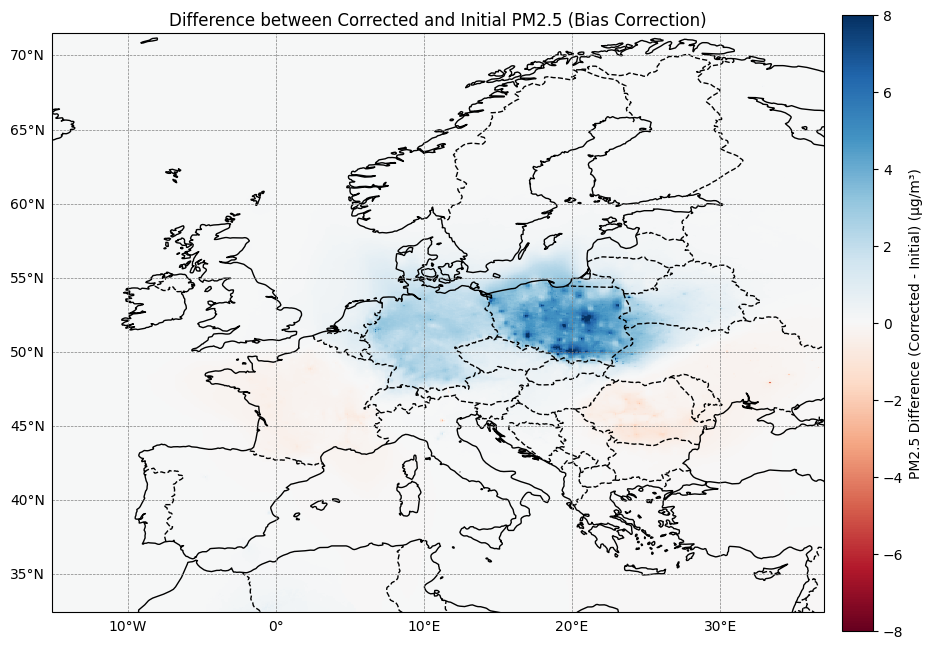

In [50]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === Load the Initial and Corrected NetCDF Files ===
initial_netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
corrected_netcdf_path = "BaseCase_PM25_rh50_Y_IDW_mul.nc"  # Change this if needed

# Open NetCDF datasets
ds_initial = xr.open_dataset(initial_netcdf_path)
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract PM2.5 data (Ensure no time dimension)
initial_pm25 = ds_initial["SURF_ug_PM25_rh50"].squeeze().values
corrected_pm25 = ds_corrected["SURF_ug_PM25_rh50_corrected"].squeeze().values

# Compute difference (Corrected - Initial) and ensure correct shape
difference = (corrected_pm25 - initial_pm25).squeeze()

# Extract coordinates
lon = ds_initial["lon"].values
lat = ds_initial["lat"].values

# === Define Plot Limits ===
cbar_min = -8
cbar_max = 8

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the difference (Ensure shape consistency)
im = ax.pcolormesh(lon, lat, difference, transform=ccrs.PlateCarree(), cmap="RdBu", vmin=cbar_min, vmax=cbar_max, shading='auto')

# Add colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("PM2.5 Difference (Corrected - Initial) (µg/m³)")

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.title("Difference between Corrected and Initial PM2.5 (Bias Correction)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close datasets
ds_initial.close()
ds_corrected.close()


# IDW - Hybrid Correction (Additive & Multiplicative)

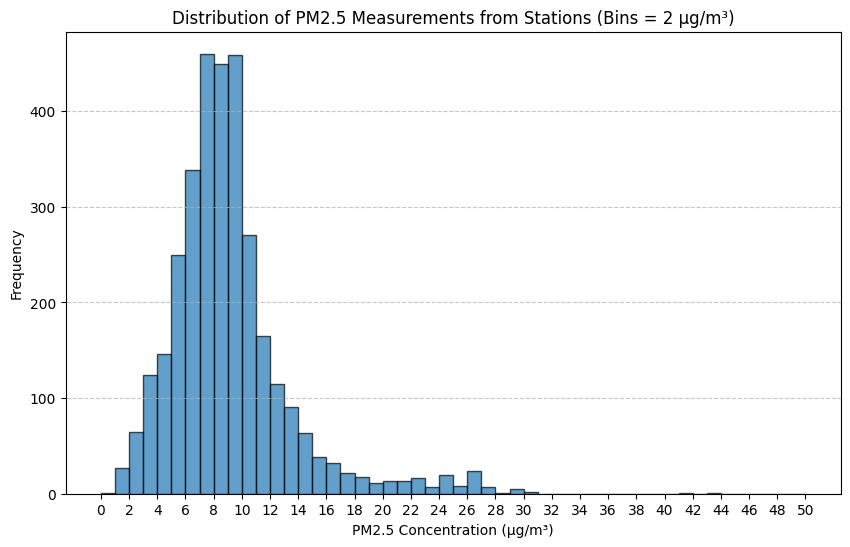

In [57]:
import matplotlib.pyplot as plt

# Φόρτωση των δεδομένων
csv_file_path = "basePM25nearest_grid.csv"
df = pd.read_csv(csv_file_path)

# Επιλογή της στήλης με τις τιμές PM2.5 από τους σταθμούς
pm25_values = df["SURF_ug_PM25_rh50"].dropna()  # Αφαίρεση NaN

# Δημιουργία ιστογράμματος με εύρος από 0 έως 50 και bins=2
plt.figure(figsize=(10,6))
plt.hist(pm25_values, bins=np.arange(0, 51, 1), edgecolor="black", alpha=0.7)

# Προσθήκη ετικετών
plt.xlabel("PM2.5 Concentration (µg/m³)")
plt.ylabel("Frequency")
plt.title("Distribution of PM2.5 Measurements from Stations (Bins = 2 µg/m³)")
plt.xticks(np.arange(0, 52, 2))
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Προβολή του γραφήματος
plt.show()

In [60]:
import os
import numpy as np
import pandas as pd
import netCDF4 as nc
from scipy.spatial import cKDTree
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import itertools

# === Load Data ===
csv_file_path = "basePM25nearest_grid.csv"
df = pd.read_csv(csv_file_path)

# Compute Additive Bias
df["bias_additive"] = df["SURF_ug_PM25_rh50"] - df["nearest_SURF_ug_PM25_rh50"]

# Compute Multiplicative Bias Ratio (Fix FutureWarning)
df["bias_ratio"] = df["SURF_ug_PM25_rh50"] / df["nearest_SURF_ug_PM25_rh50"]
df["bias_ratio"] = df["bias_ratio"].replace([np.inf, -np.inf], np.nan)  # Fix warning
df.dropna(subset=["bias_ratio"], inplace=True)

# Load NetCDF file
netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
dataset = nc.Dataset(netcdf_path, "r")

# Extract NetCDF grid coordinates
lon = dataset.variables["lon"][:]
lat = dataset.variables["lat"][:]
pm25_modeled = dataset.variables["SURF_ug_PM25_rh50"][0, :, :]

# Create meshgrid
lon_mesh, lat_mesh = np.meshgrid(lon, lat)
points_grid = np.column_stack([lon_mesh.ravel(), lat_mesh.ravel()])

# Prepare station data points
station_points = df[["nearest_grid_lon", "nearest_grid_lat"]].values
bias_additive_values = df["bias_additive"].values
bias_ratio_values = df["bias_ratio"].values

# Build KDTree for efficient nearest neighbor search
tree = cKDTree(station_points)

# === Grid Search για τα βέλτιστα p και k ===
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Προετοιμασία train-test sets
train_points = train_df[["nearest_grid_lon", "nearest_grid_lat"]].values
train_additive_values = train_df["bias_additive"].values
train_ratio_values = train_df["bias_ratio"].values

test_points = test_df[["nearest_grid_lon", "nearest_grid_lat"]].values
test_additive_values = test_df["bias_additive"].values
test_ratio_values = test_df["bias_ratio"].values

# Κατασκευή KDTree για τα train points
train_tree = cKDTree(train_points)

# Υποψήφιες τιμές για τα hyperparameters
p_values =  np.arange(0.5, 32, 2).tolist()
k_values = np.arange(5, 200, 5).tolist()
threshold = 5  # Threshold για Hybrid Correction

best_rmse = float("inf")
best_params = None

# === Grid Search για p, k ===
for p, k in itertools.product(p_values, k_values):
    predicted_additive = []
    predicted_ratio = []

    for test_point in test_points:
        dists, idxs = train_tree.query(test_point, k=k)

        if np.any(dists == 0):  # Exact match case
            predicted_additive.append(train_additive_values[idxs[dists == 0]][0])
            predicted_ratio.append(train_ratio_values[idxs[dists == 0]][0])
        else:
            weights = 1 / (dists ** p)
            interpolated_additive = np.sum(weights * train_additive_values[idxs]) / np.sum(weights)
            interpolated_ratio = np.sum(weights * train_ratio_values[idxs]) / np.sum(weights)

            predicted_additive.append(interpolated_additive)
            predicted_ratio.append(interpolated_ratio)

    # Υπολογισμός RMSE
    rmse_additive = np.sqrt(mean_squared_error(test_additive_values, predicted_additive))
    rmse_ratio = np.sqrt(mean_squared_error(test_ratio_values, predicted_ratio))
    rmse_total = (rmse_additive + rmse_ratio) / 2  # Μέσο RMSE

    if rmse_total < best_rmse:
        best_rmse = rmse_total
        best_params = (p, k)

print(f"\nBest parameters found: p={best_params[0]}, k={best_params[1]} with RMSE={best_rmse:.4f}")

# === Hybrid IDW Function ===
def idw_hybrid(grid_points, station_points, bias_additive, bias_ratio, pm25_modeled, p, k, threshold):
    interpolated = np.zeros(grid_points.shape[0])

    for i in tqdm(range(grid_points.shape[0]), desc="Interpolating Hybrid IDW", unit="grid point"):
        dists, idxs = tree.query(grid_points[i], k=k)

        if np.any(dists == 0):  # Exact match case
            interpolated[i] = bias_additive[idxs[dists == 0]][0]
        else:
            weights = 1 / (dists ** p)
            interpolated_additive = np.sum(weights * bias_additive[idxs]) / np.sum(weights)
            interpolated_ratio = np.sum(weights * bias_ratio[idxs]) / np.sum(weights)

            # Hybrid Correction Logic
            if pm25_modeled.ravel()[i] < threshold:
                interpolated[i] = interpolated_additive  # Additive Correction
            else:
                interpolated[i] = (interpolated_ratio - 1) * pm25_modeled.ravel()[i]  # Multiplicative Correction

    return interpolated

# === Apply Hybrid Correction ===
print("\nInterpolating bias using Hybrid IDW method with optimized parameters...")
interpolated_bias_hybrid = idw_hybrid(points_grid, station_points, bias_additive_values, bias_ratio_values, pm25_modeled, best_params[0], best_params[1], threshold)

# === Reshape πριν την πρόσθεση για διόρθωση ===
interpolated_bias_hybrid = interpolated_bias_hybrid.reshape(pm25_modeled.shape)

# === Apply correction correctly ===
corrected_pm25_hybrid = pm25_modeled + interpolated_bias_hybrid

# === Save Corrected NetCDF ===
corrected_netcdf_path = "BaseCase_PM25_rh50_Y_IDW_ΗΥΒΑΜ.nc"

if os.path.exists(corrected_netcdf_path):
    os.remove(corrected_netcdf_path)
    print(f"Deleted existing file: {corrected_netcdf_path}")

new_dataset = nc.Dataset(corrected_netcdf_path, "w", format="NETCDF4")

# Create dimensions
new_dataset.createDimension("lat", lat.shape[0])
new_dataset.createDimension("lon", lon.shape[0])

# Create variables
lat_var = new_dataset.createVariable("lat", "f4", ("lat",))
lon_var = new_dataset.createVariable("lon", "f4", ("lon",))
pm25_var = new_dataset.createVariable("SURF_ug_PM25_rh50_corrected", "f4", ("lat", "lon"))

# Assign metadata BEFORE writing data
pm25_var.setncatts(dataset.variables["SURF_ug_PM25_rh50"].__dict__)
new_dataset.description = "Bias-corrected PM2.5 using Hybrid IDW (Additive & Multiplicative)"

# Assign data
lat_var[:] = lat
lon_var[:] = lon
pm25_var[:, :] = corrected_pm25_hybrid

# Close files
new_dataset.close()
dataset.close()

print("Hybrid IDW Correction completed successfully! Corrected NetCDF file saved as", corrected_netcdf_path)



Best parameters found: p=2.5, k=25 with RMSE=0.2744

Interpolating bias using Hybrid IDW method with optimized parameters...


Interpolating Hybrid IDW: 100%|██████████| 406901/406901 [00:50<00:00, 8015.25grid point/s]

Deleted existing file: BaseCase_PM25_rh50_Y_IDW_ΗΥΒΑΜ.nc
Hybrid IDW Correction completed successfully! Corrected NetCDF file saved as BaseCase_PM25_rh50_Y_IDW_ΗΥΒΑΜ.nc


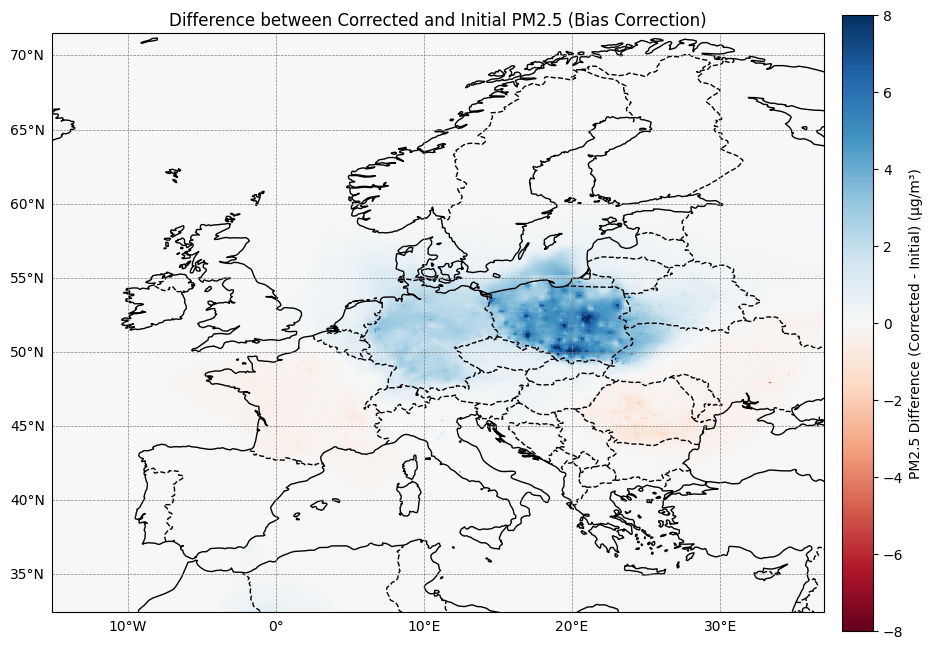

In [59]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === Load the Initial and Corrected NetCDF Files ===
initial_netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
corrected_netcdf_path = "BaseCase_PM25_rh50_Y_IDW_ΗΥΒΑΜ.nc"  # Change this if needed

# Open NetCDF datasets
ds_initial = xr.open_dataset(initial_netcdf_path)
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract PM2.5 data (Ensure no time dimension)
initial_pm25 = ds_initial["SURF_ug_PM25_rh50"].squeeze().values
corrected_pm25 = ds_corrected["SURF_ug_PM25_rh50_corrected"].squeeze().values

# Compute difference (Corrected - Initial) and ensure correct shape
difference = (corrected_pm25 - initial_pm25).squeeze()

# Extract coordinates
lon = ds_initial["lon"].values
lat = ds_initial["lat"].values

# === Define Plot Limits ===
cbar_min = -8
cbar_max = 8

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the difference (Ensure shape consistency)
im = ax.pcolormesh(lon, lat, difference, transform=ccrs.PlateCarree(), cmap="RdBu", vmin=cbar_min, vmax=cbar_max, shading='auto')

# Add colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("PM2.5 Difference (Corrected - Initial) (µg/m³)")

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.title("Difference between Corrected and Initial PM2.5 (Bias Correction)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close datasets
ds_initial.close()
ds_corrected.close()


# IDW - Hybrid Correction (Additive & Rescaled)

In [ ]:
import numpy as np
import pandas as pd
import netCDF4 as nc
from scipy.spatial import cKDTree
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import itertools

# === Load Data ===
csv_file_path = "basePM25nearest_grid.csv"
df = pd.read_csv(csv_file_path)

# Compute Additive Bias
df["bias_additive"] = df["SURF_ug_PM25_rh50"] - df["nearest_SURF_ug_PM25_rh50"]

# Load NetCDF file
netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
dataset = nc.Dataset(netcdf_path, "r")

# Extract NetCDF grid coordinates
lon = dataset.variables["lon"][:]
lat = dataset.variables["lat"][:]
pm25_modeled = dataset.variables["SURF_ug_PM25_rh50"][0, :, :]

# Create meshgrid
lon_mesh, lat_mesh = np.meshgrid(lon, lat)
points_grid = np.column_stack([lon_mesh.ravel(), lat_mesh.ravel()])

# Prepare station data points
station_points = df[["nearest_grid_lon", "nearest_grid_lat"]].values
bias_additive_values = df["bias_additive"].values

# Build KDTree for efficient nearest neighbor search
tree = cKDTree(station_points)

# === Hybrid IDW Function (Additive + Rescaled Additive) ===
def idw_hybrid_rescaled(grid_points, station_points, bias_additive, pm25_modeled, p=2, k=5, threshold=15):
    interpolated = np.zeros(grid_points.shape[0])

    for i in tqdm(range(grid_points.shape[0]), desc="Interpolating Hybrid IDW", unit="grid point"):
        dists, idxs = tree.query(grid_points[i], k=k)

        if np.any(dists == 0):  # Exact match case
            interpolated[i] = bias_additive[idxs[dists == 0]][0]
        else:
            weights = 1 / (dists ** p)
            interpolated_additive = np.sum(weights * bias_additive[idxs]) / np.sum(weights)

            # Υπολογισμός συντελεστή κλιμάκωσης (λ) για Rescaled Additive
            station_lons, station_lats = station_points[idxs].T
            grid_indices = np.array([np.argmin(np.abs(lon - lon_val)) for lon_val in station_lons])
            lat_indices = np.array([np.argmin(np.abs(lat - lat_val)) for lat_val in station_lats])
            scaling_factor = np.sum(weights * pm25_modeled[lat_indices, grid_indices]) / np.sum(weights)

            # Hybrid Correction Logic
            if pm25_modeled.ravel()[i] < threshold:
                interpolated[i] = interpolated_additive  # Additive Correction
            else:
                interpolated[i] = scaling_factor * interpolated_additive  # Rescaled Additive Correction

    return interpolated

# === Apply Hybrid Correction (Additive + Rescaled Additive) ===
print("\nInterpolating bias using Hybrid IDW (Additive + Rescaled Additive)...")
interpolated_bias_hybrid = idw_hybrid_rescaled(points_grid, station_points, bias_additive_values, pm25_modeled)

# Reshape the result to match the grid shape
interpolated_bias_hybrid = interpolated_bias_hybrid.reshape(pm25_modeled.shape)

# Apply correction
corrected_pm25_hybrid = pm25_modeled + interpolated_bias_hybrid

# === Save the Corrected NetCDF File ===
corrected_netcdf_path = "corrected_pm25_hybrid_rescaled.nc"

if os.path.exists(corrected_netcdf_path):
    os.remove(corrected_netcdf_path)
    print(f"Deleted existing file: {corrected_netcdf_path}")

new_dataset = nc.Dataset(corrected_netcdf_path, "w", format="NETCDF4")

# Create dimensions
new_dataset.createDimension("lat", lat.shape[0])
new_dataset.createDimension("lon", lon.shape[0])

# Create variables
lat_var = new_dataset.createVariable("lat", "f4", ("lat",))
lon_var = new_dataset.createVariable("lon", "f4", ("lon",))
pm25_var = new_dataset.createVariable("SURF_ug_PM25_rh50_corrected", "f4", ("lat", "lon"))

# Assign metadata BEFORE writing data
pm25_var.setncatts(dataset.variables["SURF_ug_PM25_rh50"].__dict__)
new_dataset.description = "Bias-corrected PM2.5 using Hybrid IDW (Additive + Rescaled Additive)"

# Assign data
lat_var[:] = lat
lon_var[:] = lon
pm25_var[:, :] = corrected_pm25_hybrid

# Close new NetCDF file
new_dataset.close()
dataset.close()

print("Hybrid IDW (Additive + Rescaled Additive) Correction completed successfully! Corrected NetCDF file saved as", corrected_netcdf_path)



Interpolating bias using Hybrid IDW (Additive + Rescaled Additive)...


Interpolating Hybrid IDW: 100%|██████████| 406901/406901 [07:29<00:00, 904.53grid point/s] 

Hybrid IDW (Additive + Rescaled Additive) Correction completed successfully! Corrected NetCDF file saved as corrected_pm25_hybrid_rescaled.nc


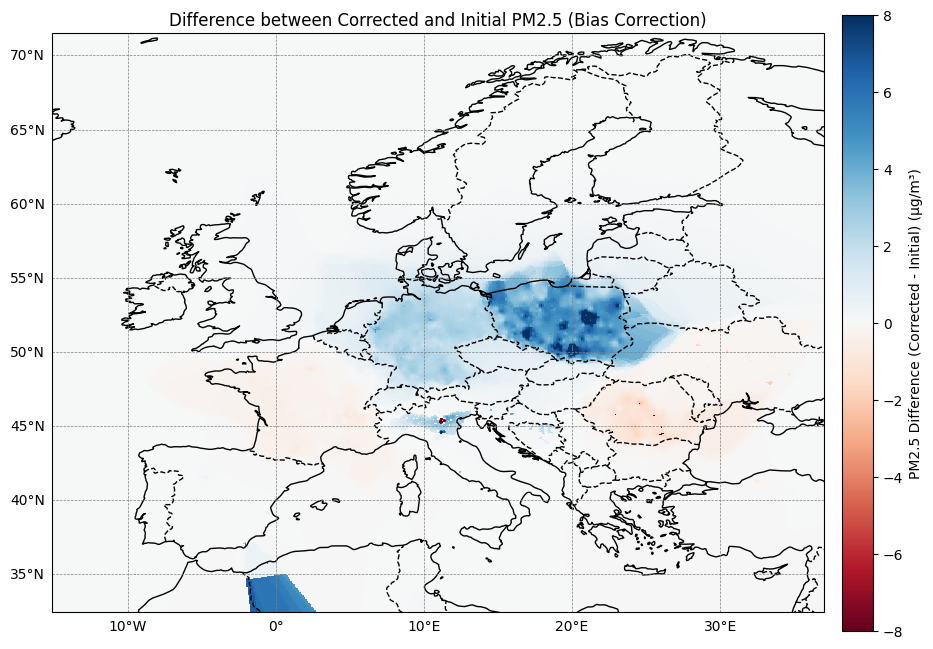

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === Load the Initial and Corrected NetCDF Files ===
initial_netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
corrected_netcdf_path = "corrected_pm25_hybrid_rescaled.nc"

# Open NetCDF datasets
ds_initial = xr.open_dataset(initial_netcdf_path)
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract PM2.5 data (Ensure no time dimension)
initial_pm25 = ds_initial["SURF_ug_PM25_rh50"].squeeze().values
corrected_pm25 = ds_corrected["SURF_ug_PM25_rh50_corrected"].squeeze().values

# Compute difference (Corrected - Initial) and ensure correct shape
difference = (corrected_pm25 - initial_pm25).squeeze()

# Extract coordinates
lon = ds_initial["lon"].values
lat = ds_initial["lat"].values

# === Define Plot Limits ===
cbar_min = -8
cbar_max = 8

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the difference (Ensure shape consistency)
im = ax.pcolormesh(lon, lat, difference, transform=ccrs.PlateCarree(), cmap="RdBu", vmin=cbar_min, vmax=cbar_max, shading='auto')

# Add colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("PM2.5 Difference (Corrected - Initial) (µg/m³)")

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.title("Difference between Corrected and Initial PM2.5 (Bias Correction)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close datasets
ds_initial.close()
ds_corrected.close()


# IDW - Hybrid Correction (Multiplicative & Rescaled)

In [ ]:
import numpy as np
import pandas as pd
import netCDF4 as nc
from scipy.spatial import cKDTree
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import itertools

# === Load Data ===
csv_file_path = "basePM25nearest_grid.csv"
df = pd.read_csv(csv_file_path)

# Compute Multiplicative Bias Ratio
df["bias_ratio"] = df["SURF_ug_PM25_rh50"] / df["nearest_SURF_ug_PM25_rh50"]
df["bias_ratio"] = df["bias_ratio"].replace([np.inf, -np.inf], np.nan)
df.dropna(subset=["bias_ratio"], inplace=True)

# Compute Additive Bias for Rescaled Additive
df["bias_additive"] = df["SURF_ug_PM25_rh50"] - df["nearest_SURF_ug_PM25_rh50"]

# Load NetCDF file
netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
dataset = nc.Dataset(netcdf_path, "r")

# Extract NetCDF grid coordinates
lon = dataset.variables["lon"][:]
lat = dataset.variables["lat"][:]
pm25_modeled = dataset.variables["SURF_ug_PM25_rh50"][0, :, :]

# Create meshgrid
lon_mesh, lat_mesh = np.meshgrid(lon, lat)
points_grid = np.column_stack([lon_mesh.ravel(), lat_mesh.ravel()])

# Prepare station data points
station_points = df[["nearest_grid_lon", "nearest_grid_lat"]].values
bias_ratio_values = df["bias_ratio"].values
bias_additive_values = df["bias_additive"].values

# Build KDTree for efficient nearest neighbor search
tree = cKDTree(station_points)

# === Grid Search για τα βέλτιστα p και k ===
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Προετοιμασία train-test sets
train_points = train_df[["nearest_grid_lon", "nearest_grid_lat"]].values
train_ratio_values = train_df["bias_ratio"].values
train_additive_values = train_df["bias_additive"].values

test_points = test_df[["nearest_grid_lon", "nearest_grid_lat"]].values
test_ratio_values = test_df["bias_ratio"].values
test_additive_values = test_df["bias_additive"].values

# Κατασκευή KDTree για τα train points
train_tree = cKDTree(train_points)

# Υποψήφιες τιμές για τα hyperparameters
p_values = [1, 2, 3]
k_values = [3, 5, 7, 10]
threshold = 15  # Threshold για Hybrid Correction

best_rmse = float("inf")
best_params = None

# === Grid Search για p, k ===
for p, k in itertools.product(p_values, k_values):
    predicted_ratio = []
    predicted_additive = []

    for test_point in test_points:
        dists, idxs = train_tree.query(test_point, k=k)

        if np.any(dists == 0):  # Exact match case
            predicted_ratio.append(train_ratio_values[idxs[dists == 0]][0])
            predicted_additive.append(train_additive_values[idxs[dists == 0]][0])
        else:
            weights = 1 / (dists ** p)
            interpolated_ratio = np.sum(weights * train_ratio_values[idxs]) / np.sum(weights)
            interpolated_additive = np.sum(weights * train_additive_values[idxs]) / np.sum(weights)

            predicted_ratio.append(interpolated_ratio)
            predicted_additive.append(interpolated_additive)

    # Υπολογισμός RMSE
    rmse_ratio = np.sqrt(mean_squared_error(test_ratio_values, predicted_ratio))
    rmse_additive = np.sqrt(mean_squared_error(test_additive_values, predicted_additive))
    rmse_total = (rmse_ratio + rmse_additive) / 2  # Μέσο RMSE

    if rmse_total < best_rmse:
        best_rmse = rmse_total
        best_params = (p, k)

print(f"\nBest parameters found: p={best_params[0]}, k={best_params[1]} with RMSE={best_rmse:.4f}")

# === Hybrid IDW Function (Multiplicative + Rescaled Additive) ===
def idw_hybrid_rescaled(grid_points, station_points, bias_ratio, bias_additive, pm25_modeled, p, k, threshold):
    interpolated = np.zeros(grid_points.shape[0])

    for i in tqdm(range(grid_points.shape[0]), desc="Interpolating Hybrid IDW", unit="grid point"):
        dists, idxs = tree.query(grid_points[i], k=k)

        if np.any(dists == 0):  # Exact match case
            interpolated[i] = bias_ratio[idxs[dists == 0]][0]
        else:
            weights = 1 / (dists ** p)
            interpolated_ratio = np.sum(weights * bias_ratio[idxs]) / np.sum(weights)
            interpolated_additive = np.sum(weights * bias_additive[idxs]) / np.sum(weights)

            # Υπολογισμός συντελεστή κλιμάκωσης (λ)
            station_lons, station_lats = station_points[idxs].T
            grid_indices = np.array([np.argmin(np.abs(lon - lon_val)) for lon_val in station_lons])
            lat_indices = np.array([np.argmin(np.abs(lat - lat_val)) for lat_val in station_lats])
            scaling_factor = np.sum(weights * pm25_modeled[lat_indices, grid_indices]) / np.sum(weights)

            # Hybrid Correction Logic
            if pm25_modeled.ravel()[i] < threshold:
                interpolated[i] = (interpolated_ratio - 1) * pm25_modeled.ravel()[i]  # Multiplicative Correction
            else:
                interpolated[i] = scaling_factor * interpolated_additive  # Rescaled Additive Correction

    return interpolated

# === Apply Hybrid Correction (Multiplicative + Rescaled Additive) ===
print("\nInterpolating bias using Hybrid IDW (Multiplicative + Rescaled Additive) with optimized parameters...")
interpolated_bias_hybrid = idw_hybrid_rescaled(points_grid, station_points, bias_ratio_values, bias_additive_values, pm25_modeled, best_params[0], best_params[1], threshold)

# Reshape the result to match the grid shape
interpolated_bias_hybrid = interpolated_bias_hybrid.reshape(pm25_modeled.shape)

# Apply correction
corrected_pm25_hybrid = pm25_modeled + interpolated_bias_hybrid

print("Hybrid IDW (Multiplicative + Rescaled Additive) Correction completed successfully!")



Best parameters found: p=2, k=10 with RMSE=0.2750

Interpolating bias using Hybrid IDW (Multiplicative + Rescaled Additive) with optimized parameters...


Interpolating Hybrid IDW: 100%|██████████| 406901/406901 [12:07<00:00, 559.44grid point/s]

Hybrid IDW (Multiplicative + Rescaled Additive) Correction completed successfully!


In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === Load the Initial and Corrected NetCDF Files ===
initial_netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
corrected_netcdf_path = "corrected_pm25_hybrid_rescaled.nc"

# Open NetCDF datasets
ds_initial = xr.open_dataset(initial_netcdf_path)
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract PM2.5 data (Ensure no time dimension)
initial_pm25 = ds_initial["SURF_ug_PM25_rh50"].squeeze().values
corrected_pm25 = ds_corrected["SURF_ug_PM25_rh50_corrected"].squeeze().values

# Compute difference (Corrected - Initial) and ensure correct shape
difference = (corrected_pm25 - initial_pm25).squeeze()

# Extract coordinates
lon = ds_initial["lon"].values
lat = ds_initial["lat"].values

# === Define Plot Limits ===
cbar_min = -8
cbar_max = 8

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the difference (Ensure shape consistency)
im = ax.pcolormesh(lon, lat, difference, transform=ccrs.PlateCarree(), cmap="RdBu", vmin=cbar_min, vmax=cbar_max, shading='auto')

# Add colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("PM2.5 Difference (Corrected - Initial) (µg/m³)")

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.title("Difference between Corrected and Initial PM2.5 (Bias Correction)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close datasets
ds_initial.close()
ds_corrected.close()
